In [3]:
import numpy as np
import matplotlib.pyplot as plt
from ppr.robot import Robot, Robot_3R
from ppr.path import TrajectoryPt, TolerancedNumber
from ppr.geometry import Rectangle

### custom robot definition
Redefine the 2P3R robot in order to play with the inverse kinematics

In [4]:
class Robot_2P3R(Robot):
    """ A 3R robot mounted on a 2P cartesian robot
    
    This is the first robot with kinematic redundancy!
    
    Attributes
    ----------
    ik_sample : int
            How many samples should be taken in the range of the first two
            joints. Resulting in n_sample * n_sample times the normal number
            of solutions for a 3R robot.
    """
    def __init__(self, link_length):
        """ Simplified constructor for this 2P3R robot
        
        Add a helper robot to self.sub_robot to reuse the inverse kinematics
        implementation of the 3R robot.
        
        Parameters
        ----------
        link_length : list or np.array of floats
            The lengths for the two links.
        """
        if not (len(link_length) == 5):
            raise ValueError("This robot has 5 links, not: " + str(len(link_length)))
        super().__init__(['p', 'p', 'r', 'r', 'r'],
                         link_length,
                         [np.pi / 2, -np.pi / 2, 0, 0, 0])
        # create 3R robot for inverse kinematics
        self.sub_robot = Robot_3R(link_length[2:])
        self.ik_samples = 5

    def ik(self, p):
        """ Discretised / sampled inverse kinematics
        
        This robots has redundance (ndof = 5) compared to the task (3) and
        therefore two joints are sampled in a range to return a sampled
        subset of the infinite solutions that exists for the given pose.
        
        Parameters
        ----------
        p : list or np.ndarray of floats
            End-effector pose (x, y, angle)
        
        Returns
        -------
        dict
            A dictionary with a key 'success' reporting True if the pose is
            reachable and a key 'q' reporting the different joint solutions
            as a list of numpy arrays.
            If 'success' is False, a key 'info' containts extra info.
        """
        q1 = TolerancedNumber(0.5, 0.5, 1.0, samples=3)
        q2 = TolerancedNumber(2.5, 2, 3, samples=self.ik_samples)
        grid = np.meshgrid(q1.range, q2.range)
        grid = [ grid[i].flatten() for i in range(2) ]
        grid = np.array(grid).T
        
        q_sol = []
        for qf in grid:
            s = self.ik_fixed_joints(p, q_fixed=qf)
            if s['success']:
                for qi in s['q']:
                    q_sol.append(qi)
        if len(q_sol) > 0:
            return {'success': True, 'q': q_sol}
        else:
            return {'success' : False, 'info': "unreachable"}
    
    def ik_fixed_joints(self, p, q_fixed = [0, 0]):
        """ wrapper function to solve the ik for the last three joints.
        
        The joint solution of the 3R robot is extended with the joint values
        for the fixed joints.
        
        Parameters
        ----------
        p : list or np.ndarray of floats
            End-effector pose (x, y, angle) 
        dict
            A dictionary with a key 'success' reporting True if the pose is
            reachable and a key 'q' reporting the different joint solutions
            as a list of numpy arrays.
            If 'success' is False, a key 'info' containts extra info.
        """
        q_base = [0, 0, 0]
        q_base[0] = q_fixed[1]
        q_base[1] = q_fixed[0]
        self.sub_robot.base = q_base
        sub_sol = self.sub_robot.ik(p)
        if sub_sol['success']:
            # add fixed joints to solution
            q_sol = []
            for qi in sub_sol['q']:
                q_sol.append([*q_fixed, *qi])
            sub_sol['q'] = q_sol
        return sub_sol

In [5]:
# ROBOT
robot1 = Robot_2P3R([1, 1, 2, 1.2, 1])

# PATH
dx    = TolerancedNumber(0.5, 0.3, 0.8, samples=4)
dy    = np.linspace(2, 2.5, 5)
angle = TolerancedNumber(0.0, -np.pi, np.pi, samples=20)
path1 = [TrajectoryPt([dx, yi, angle]) for yi in dy]

# COLLISION SCENE
sc1 = [Rectangle(1, 1, 1, 1.5, 0),
       Rectangle(3, 1, 1, 2.2, 0),
       Rectangle(0, 3.2, 4, 0.5, 0),
       Rectangle(0, 1, 0.2, 3.2, 0),
       Rectangle(0.2, 1, 0.8, 0.5, 0)]

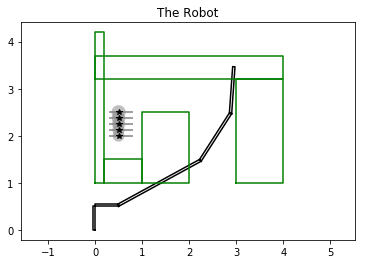

In [7]:
fig1, ax1 = plt.subplots()
plt.title("The Robot")
ax1.axis('equal')
robot1.plot(ax1, [0.5, 0.5, 0.5, 0.5, 0.5], 'k')
for tp in path1: tp.plot(ax1)
for r in sc1: r.plot(ax1, 'g')
plt.show()

In [8]:
from ppr.path import cart_to_joint
from ppr.path import get_shortest_path

In [9]:
path_js = cart_to_joint(robot1, path1, check_collision=True, scene=sc1)

In [10]:
print([len(qp) for qp in path_js])

[15, 25, 27, 42, 72]


In [11]:
sol = get_shortest_path(path_js)
print(sol['success'])

converting type of Q
[ 6 18  6 31 51]
True


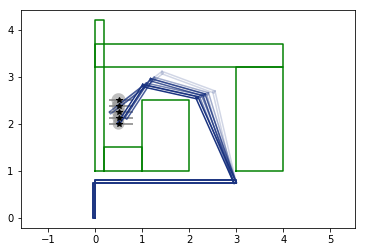

In [12]:
fig2, ax2 = plt.subplots()
ax2.axis('equal')
#robot1.plot_path_kinematics(ax2, path_js[2])
robot1.plot_path(ax2, sol['path'])
for r in sc1: r.plot(ax2, 'g')
for tp in path1: tp.plot(ax2)
plt.show()

In [24]:
from ppr.optim import get_optimal_trajectory

In [29]:
q_init = sol['path']
#q_init = np.zeros((len(path1), robot1.ndof))
#q_init = np.random.rand(len(path1), robot1.ndof)
q_opt, _, _ = get_optimal_trajectory(robot1, path1, q_init, check_collision=True, scene=sc1)

Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.19452932789741406
            Iterations: 101
            Function evaluations: 2898
            Gradient evaluations: 101


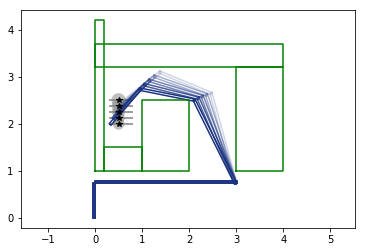

In [30]:
fig3, ax3 = plt.subplots()
ax3.axis('equal')
robot1.plot_path(ax3, q_opt)
for r in sc1: r.plot(ax3, 'g')
for tp in path1: tp.plot(ax3)
plt.show()